In [210]:
import ss13

from typing import NamedTuple
from enum import Enum, IntEnum
from typing_extensions import Self
import importlib
from dataclasses import dataclass

import supermattercore.graph as smg
importlib.reload(smg)
from supermattercore.graph import Direction

In [231]:
SCAV_ROOT = "E:\\Code\\opensource\\games\\ScavStation\\maps/ministation/"
# SCAV_ROOT = "./instance/"
ssm = ss13.Ss13Map(SCAV_ROOT + "ministation-0.dmm")

[last stable?](https://github.com/ScavStation/ScavStation/tree/b483fa24e432795be96931983d59152cc6628d8d/maps/ministation)

In [232]:
# using scheme notations 
match_path = lambda s1, s2: all([a==b for a,b in zip(s1.split('/'), s2.split('/'))] )
ATMOS = '/obj/machinery/atmospherics' 
OBJS = {
    ATMOS + '/portables_connector':     'C',
    ATMOS + '/omni/filter':             'F',
    '/obj/machinery/generator':         'G',
    ATMOS + '/unary/heat_exchanger':    'HE',
    '/obj/machinery/meter':             'M',
    ATMOS + '/binary/pump':             'P',
    ATMOS + '/unary/vent_pump':         'PI',
    ATMOS + '/unary/outlet_injector':   'PO',
    ATMOS + '/binary/circulator':       'T',
    ATMOS + '/valve':                   'V',
    ATMOS + '/pipe':                    '_',
}
ARITY = {'C': 1, 'F': 4, 'G': 4, 'HE': 2, 'M': 0, 'P': 2, 'PI': 1, 'PO': 1, 'T': 2, 'V': 2, 'M': 4}

In [233]:
class StoredObj(NamedTuple):
    coords: tuple[int, int]
    path: str
    attrs:  dict
    symbol: str

    def __eq__(self, o):
        return self.coords==o.coords and self.path==o.path
    @property
    def dir_attr(self) -> Direction:
        attrdir = self.attrs.get('dir')
        if attrdir is not None:
            assert isinstance(attrdir,ss13.ByondConst.Float)
            return Direction(attrdir.f)
        return Direction(2) # looks default?
    
    @property
    def conn_dirs(self) -> set[Direction]:
        dirval = self.dir_attr
        arity = ARITY.get(self.symbol)
        if self.symbol == '_':
            # pipes are magic
            if 'manifold' in self.path:
                assert not dirval.is_composite
                return set(Direction.cardinals()) - {dirval}
            # else it's binary pipe
            if dirval.is_composite:
                return dirval.split()
            arity = 2 # as normal binary
        if arity == 0: return {}
        if arity == 2: return {dirval, ~dirval}
        if arity == 4: return set(Direction.cardinals())
        return {dirval}

In [234]:
VACUUM_FLOOR = '/turf/simulated/floor/reinforced/airless'
AIRLOCK = '/obj/machinery/door/airlock/atmos'
SM_CORE = '/obj/machinery/power/supermatter'


core_room = [k for k in ssm.find(VACUUM_FLOOR) if AIRLOCK not in dict(ssm[k])]
smcore = [StoredObj(k, SM_CORE, dict(ssm[k])[SM_CORE], 'SM') for k in core_room if SM_CORE in dict(ssm[k])]
assert len(smcore)>0, "SM core not located"
core_volume = 2.5 * len(core_room)
print(f'{core_volume=} m³')

core_volume=37.5 m³


In [235]:
seen_objs : dict[tuple[int,int], StoredObj] = {smcore[0][0]: [smcore[0]]}
next_objs = [(StoredObj(k, a, b, OBJS[v]), None) for v in OBJS for k in core_room for (a, b) in ssm[k] if match_path(a,v)]

# Parse all connected objects [primary]
while len(next_objs) > 0:
    prev_objs = next_objs
    # print(len(prev_objs))
    next_objs = []
    for o, dir in prev_objs:
        if o.coords in seen_objs: 
            if any(o==k for k in seen_objs[o.coords]):
                continue
            # print(o, seen_objs[o.coords])
        if dir is not None and dir not in o.conn_dirs: continue # wrong pipe
        coords = [(k.move1(o.coords), ~k) for k in (o.conn_dirs - {dir})]
        next_objs += [(StoredObj(k, a, b, OBJS[v]), d) for v in OBJS for (k,d) in coords for (a, b) in ssm[k] if match_path(a,v)]
        seen_objs[o.coords] = seen_objs.get(o.coords, []) + [o]

In [236]:
stored_objs = {}
known_pipes = []
# Split objs to pipes and devices
for k,os in seen_objs.items():
    for o in os:
        if o.symbol == '_': 
            known_pipes.append(o)
        else:
            stored_objs[o.symbol] = stored_objs.get(o.symbol, []) + [o]
del seen_objs

In [237]:
seen_pipes = {}
remaps = {}
pipenets: dict[int, set[tuple[int,int]]] = {} 
pipedefs: dict[int, str] = {} 
pipejoins: set[tuple[int,int]] = set() # pair of pipenet indices
ix = 1
# Merge pipes
while len(known_pipes) > 0:
    o = known_pipes.pop() # pipe
    k = o.coords
    if k in seen_pipes: print('?', k)
    ps = [p for p in set([seen_pipes.get(d.move1(k)) for d in o.conn_dirs]) if p]
    # pointers
    equ = [p for p in ps if  ATMOS + '/pipe/' + pipedefs[p]==o.path]
    joint = [*(set(ps) - set(equ))]
    if len(equ) == 0:
        pipenets[ix], equ = {k}, [ix]
        pipedefs[ix] = '/'.join(o.path.split('/')[5:])
        ix += 1
    if len(equ) == 1: # incl =0 with new equ
        x = equ[0]
        seen_pipes[k] = x
        pipenets[x] |= {k}
    else: #2+ equivalent -- merge
        sel, *rest = ps
        for p in rest:
            for x in pipenets[p]:
                seen_pipes[x] = sel
            pipenets[sel] |= pipenets[p]
            remaps[p] = sel
            del pipenets[p]
    if len(joint) > 0:
        pipejoins |= {tuple(sorted([equ[0], j])) for j in joint}

? (132, 64)


In [238]:
pipeseqs = []
for a,b in pipejoins:
    a = remaps.get(a,a)
    b = remaps.get(b,b)
    founds = [s for s in pipeseqs if a in s or b in s]
    rests =  [s for s in pipeseqs if not (a in s or b in s)]
    # print(a,b,pipeseqs)
    if len(founds) == 0:
        pipeseqs.append({a, b})
        continue
    pipeseqs = [*rests, set.union(*founds, {a, b})]

In [239]:
import pprint

In [240]:
print('Dev set:')
for v in pipeseqs:
    clrtmp = {}
    for a in v:
        s = pipedefs[a].replace('simple','/').replace('visible','')
        clrtmp[s] = clrtmp.get(s, 0) + len(pipenets[a])
    print(sum(clrtmp.values()),':')
    pprint.pprint(clrtmp, indent = 4)
    

Dev set:
3 :
{'///cyan': 1, 'manifold//cyan': 2}
30 :
{   '///black': 3,
    '//heat_exchanging': 21,
    '//heat_exchanging/junction': 2,
    '//hidden/black': 1,
    'manifold//black': 3}
20 :
{'///cyan': 17, 'manifold//cyan': 3}
5 :
{'///black': 4, 'manifold//black': 1}
4 :
{'///yellow': 3, 'manifold//yellow': 1}
222 :
{   '///black': 8,
    '///green': 19,
    '//heat_exchanging': 189,
    '//heat_exchanging/junction': 2,
    'manifold//black': 2,
    'manifold//green': 2}
4 :
{'///black': 2, 'manifold//black': 2}


In [230]:
print('Oly set:')
for v in pipeseqs:
    clrtmp = {}
    for a in v:
        s = pipedefs[a].replace('simple','/').replace('visible','')
        clrtmp[s] = clrtmp.get(s, 0) + len(pipenets[a])
    print(sum(clrtmp.values()),':')
    pprint.pprint(clrtmp, indent = 4)
    

Oly set:
5 :
{'///black': 4, 'manifold//black': 1}
2 :
{'///green': 1, 'manifold//green': 1}
4 :
{'///yellow': 3, 'manifold//yellow': 1}
4 :
{'///black': 2, 'manifold//black': 2}
173 :
{   '///black': 6,
    '//heat_exchanging': 157,
    '//heat_exchanging/junction': 2,
    '//hidden/black': 5,
    'manifold//black': 3}
26 :
{'///cyan': 20, '//hidden/cyan': 2, 'manifold//cyan': 4}
3 :
{'///cyan': 1, 'manifold//cyan': 2}
162 :
{   '///black': 15,
    '///green': 5,
    '//heat_exchanging': 119,
    '//heat_exchanging/junction': 2,
    '//hidden/black': 4,
    '//hidden/green': 13,
    'manifold//black': 2,
    'manifold//green': 1,
    'manifold/hidden/green': 1}


In [220]:
print('Archived set:')
for v in pipeseqs:
    clrtmp = {}
    for a in v:
        s = pipedefs[a].replace('simple','/').replace('visible','')
        clrtmp[s] = clrtmp.get(s, 0) + len(pipenets[a])
    print(sum(clrtmp.values()),':')
    pprint.pprint(clrtmp, indent = 4)
    

Archived set:
5 :
{'///black': 4, 'manifold//black': 1}
2 :
{'///green': 1, 'manifold//green': 1}
4 :
{'///yellow': 3, 'manifold//yellow': 1}
4 :
{'///black': 2, 'manifold//black': 2}
173 :
{   '///black': 6,
    '//heat_exchanging': 157,
    '//heat_exchanging/junction': 2,
    '//hidden/black': 5,
    'manifold//black': 3}
26 :
{'///cyan': 20, '//hidden/cyan': 2, 'manifold//cyan': 4}
3 :
{'///cyan': 1, 'manifold//cyan': 2}
162 :
{   '///black': 15,
    '///green': 5,
    '//heat_exchanging': 119,
    '//heat_exchanging/junction': 2,
    '//hidden/black': 4,
    '//hidden/green': 13,
    'manifold//black': 2,
    'manifold//green': 1,
    'manifold/hidden/green': 1}


In [180]:
print('Current set:')
for v in pipeseqs:
    clrtmp = {}
    for a in v:
        s = pipedefs[a].replace('simple','/').replace('visible','')
        clrtmp[s] = clrtmp.get(s, 0) + len(pipenets[a])
    print(sum(clrtmp.values()),':')
    pprint.pprint(clrtmp, indent = 4)
    

Current set:
3 :
{'///cyan': 1, 'manifold//cyan': 2}
30 :
{   '///black': 3,
    '//heat_exchanging': 21,
    '//heat_exchanging/junction': 2,
    '//hidden/black': 1,
    'manifold//black': 3}
20 :
{'///cyan': 17, 'manifold//cyan': 3}
5 :
{'///black': 4, 'manifold//black': 1}
4 :
{'///yellow': 3, 'manifold//yellow': 1}
222 :
{   '///black': 8,
    '///green': 19,
    '//heat_exchanging': 189,
    '//heat_exchanging/junction': 2,
    'manifold//black': 2,
    'manifold//green': 2}
4 :
{'///black': 2, 'manifold//black': 2}


In [90]:
[k.next_dir() for k in next_chk]

[{<Direction.EAST: 4>}, {<Direction.NORTH: 1>}]

In [62]:
ssm[128,66]

[('/obj/machinery/atmospherics/unary/vent_pump/engine',
  {'external_pressure_bound': 100,
   'id_tag': "cooling_out",
   'dir': 4,
   'external_pressure_bound_default': 0,
   'icon_state': "map_vent_in",
   'use_power': 1,
   'pump_direction': 0,
   'initialize_directions': 1}),
 ('/turf/simulated/floor/reinforced/airless', {}),
 ('/area/ministation/engineroom', {})]

# Previous iter

In [4]:
nodes = ['Core', 'injector', 'vent_pump']
edges = [('Core', 'vent_pump'), ('injector', 'Core')]
cur_ptr = {
    'injector':  ({len([v for v in mapobjs[k] if 'injector' in v]): k for k in core_room}[1],  None, True),
    'vent_pump': ({len([v for v in mapobjs[k] if 'vent_pump' in v]): k for k in core_room}[1], None, False)
    }
attrs = {}
volumes = {'Core': core_volume, 'injector': 0.7, 'vent_pump': 0.2}
ixs = {}
consumed = {k: 'Core' for k in core_room}
# del mapobjs

In [5]:
def dict2dir(x: dict[str, str]) -> Direction|None:
    s = x.get('dir', None)
    if s is None: return None
    i = int(float(s[-5:-1].strip('(')))
    return Direction(i)

In [6]:
def consume_pipe(mapdata, dir0, *coords0):
    """Перебирая данные в `mapdata`, поглотить весь сплошной участок труб от coords0 по напр. dir0 """
    next_pipe = [(name, vals) for (name,vals) in mapdata[coords0] if 'pipe' in name and dir0.matches(dict2dir(vals))] 
    coords1,direff = coords0, dir0
    colors = {}
    # seg_len = 0
    trace=[]
    while len(next_pipe)==1 and all([not (x in next_pipe[0][0]) for x in 'junction manifold'.split()]):
        dir0 = direff
        colors[next_pipe[0][0]] = colors.get(next_pipe[0][0],0)+1
        dir1 = dict2dir(next_pipe[0][1])
        if dir1 is None: dir1=Direction(2)
        # assert dir1 is not None, (coords0, next_pipe)
        direff = dir1^dir0 if dir1.is_composite else (dir0 if dir1==~dir0 else dir1)
        # print (dir1, dir0, direff)
        coords0=coords1
        trace.append(coords0)
        coords1 = direff.move1(coords0)
        # print(next_pipe[0][0], '@', coords0, ':', dir0, '-->', coords1)
        next_pipe = [(name, vals) for (name,vals) in mapdata[coords1] if 'pipe' in name and direff.matches(dict2dir(vals))] 
        # seg_len += 1
        # if xix==3: break
    return coords1, colors, trace, direff

In [7]:
def simplify_objclass(s: str) -> str:
    letzte = s.split('/')[-1]
    if 'manifold' in s:
        return 'manifold_'+letzte
    if 'valve' in s:
        return 'valve'
    return letzte

In [8]:
pipesets = {}
pipes_from = []
while len(cur_ptr) > 0:
    nxt_ptr = {}
    pipedups = {}
    for cur_id, (cur_xy, cur_dir, invert_edge) in cur_ptr.items():
        print('--',cur_id)
        atmos = [x for x in maparg[cur_xy] if 'atmosp' in x[0]]
        if len(atmos)>1:
            print('????', [x[0] for x in atmos])
            atmos = [x for x in atmos if 'pipe' not in x[0] and 'canister' not in x[0]]
        assert len(atmos)==1, (cur_xy)
        objname, vals = atmos[0]
        dir0 = dict2dir(vals) #  or cur_dir # or Direction(2) # TODO: TEST
        attrs[cur_id] = (objname, vals, cur_xy)
        consumed.update({cur_xy: cur_id})
        if 'manifold' in objname:
            dir0 = dir0 or Direction(2)
            sdirs = [Direction(x) for x in {1,2,4,8} - {int(dir0)}]
        elif any([k in objname for k in 'omni'.split()]):
            sdirs = [Direction(x) for x in {1,2,4,8}]    
        elif any([k in objname for k in 'valve circulator binary junction unary/heat'.split()]):
            dir0 = dir0 or cur_dir
            sdirs = [dir0, ~dir0]
        elif any([k in objname for k in 'connector canister'.split()]):
            sdirs = [] # finita
        else:  # unary
            dir0 = dir0 or cur_dir
            sdirs = [dir0]
            print ('impl?', cur_id, objname, '@', cur_xy, ':', dir0, cur_dir)
        print(sdirs)
        for sdir in sdirs:
            xy0 = sdir.move1(cur_xy)
            # print(xy, xy0, sdir)
            if xy0 in consumed: 
                print(cur_id, sdir, 'already checkd',  xy0)
                edges.append((cur_id, consumed[xy0]))
                continue
            xy1, cset, tra, ddir = consume_pipe(maparg, sdir, *xy0)
            print(len(tra),':', cur_xy, sdir, '-> next node @', xy1, ddir)
            refrevptr = tuple(sorted([tra[0], tra[-1]])) if len(tra) else None
            revptr = pipesets.get(refrevptr) 
            if revptr is not None:
                print(cur_id, sdir, 'this loop growled ', refrevptr, revptr)
                pipedups[revptr] = cur_id
                continue
            pipes_from.append((xy1, ddir, cset, tra, xy0, sdir, cur_id))
            if refrevptr is not None:
                pipesets[refrevptr] = ((cur_id, sdir))
            # consumed.update({k: None for k in trace})
            
    print('found', len(pipes_from), 'pipenets')
    pipes_new = []
    for (xynext, dirfrom, colorset, trace, xyfrom, dirst, idfrom) in pipes_from:
        print('>>', xynext, idfrom)
        if len(trace) > 0:
            colortext = '_'.join([k.split('/')[-1] for k in colorset])
            pipename = f'pipe_{colortext}_{ixs.get(colortext, 0)} x{len(trace)}'
            nodes.append(pipename)
            edges.append((idfrom, pipename))
            ixs[colortext] = ixs.get(colortext,0)+1
            attrs[pipename] = colorset
            pipesets[pipename] = set(trace)
            consumed.update({k: pipename for k in trace})
            if (idfrom, dirst) in pipedups:
                print('this loop dup added')
                edges.append((pipedups[idfrom,dirst], pipename))
            print('= new pipe', pipename, trace)
        else:
            print('skipping 0-len-pipe nodegen')
            pipename = idfrom # for 0-len `pipes`
        if xynext in consumed:
            print('pre-procd:', xynext)
            edges.append((idfrom, consumed[xynext]))
            continue
        for ojnam, simname in [(x[0],simplify_objclass(x[0])) for x in maparg[xynext] if 'atmosp' in x[0]]:
            if any([k in ojnam for k in 'hidden canister'.split()]): continue
            simix = ixs.get(simname, 0)
            ixs[simname] = simix+1
            simid = f'{simname}_{simix}'
            nxt_ptr[simid] = (xynext, dirfrom)
            edges.append((pipename, simid))
            nodes.append(simid) 
            print('+ new node', simid, '@', xynext)
    cur_ptr = nxt_ptr
    pipes_from = pipes_new
    print('---')

-- injector
impl? injector /obj/machinery/atmospherics/unary/outlet_injector @ (124, 66) : Direction.NORTH None
[<Direction.NORTH: 1>]
1 : (124, 66) Direction.NORTH -> next node @ (124, 68) Direction.NORTH
-- vent_pump
impl? vent_pump /obj/machinery/atmospherics/unary/vent_pump/engine @ (128, 66) : Direction.EAST None
[<Direction.EAST: 4>]
3 : (128, 66) Direction.EAST -> next node @ (130, 64) Direction.SOUTH
found 2 pipenets
>> (124, 68) injector
= new pipe pipe_cyan_0 x1 [(124, 67)]
+ new node manifold_cyan_0 @ (124, 68)
>> (130, 64) vent_pump
= new pipe pipe_yellow_0 x3 [(129, 66), (130, 66), (130, 65)]
+ new node manifold_yellow_0 @ (130, 64)
---
-- manifold_cyan_0
[<Direction.WEST: 8>, <Direction.SOUTH: 2>, <Direction.EAST: 4>]
1 : (124, 68) Direction.WEST -> next node @ (122, 68) Direction.WEST
manifold_cyan_0 Direction.SOUTH already checkd (124, 67)
0 : (124, 68) Direction.EAST -> next node @ (125, 68) Direction.EAST
-- manifold_yellow_0
[<Direction.NORTH: 1>, <Direction.SOUTH: 2

In [92]:
CONJ = 'pipe manifold'.split()
joint = []
ptrjoins = {}
jnptrs = {}
pairjoins = [(a,b) for a,b in edges if all([any([z.startswith(k) for k in CONJ]) for z in [a,b]])]
for a,b in pairjoins:
    cptr = ptrjoins.get(a, ptrjoins.get(b, len(joint)))
    if cptr==len(joint): joint.append(0)
    for z in [a,b]:
        if z not in ptrjoins:
            ptrjoins[z] = cptr
            joint[cptr] += sum(attrs[z].values()) if z.startswith('pipe') else 1.5
            jnptrs[cptr] = jnptrs.get(cptr, []) + [z]
for k, zs in jnptrs.items():
    clrs = {}
    for z in zs:
        if z.startswith('manifold'):
            clr = attrs[z][0].split('/')[-1]
            clrs[clr] = clrs.get(clr, 0) + 1.5 
            continue
        for objid, val in attrs[z].items():
            clr = objid.split('/')[-1]
            clrs[clr] = clrs.get(clr, 0) + val 
    clr = '_'.join([f'{k}×{v*70}' for k,v in clrs.items()])
    joint_name = f'{clr}#{k}'
    for z in zs:
        ptrjoins[z] = joint_name

In [93]:
newnodes = set([ptrjoins.get(k,k) for k in nodes])
newedges = [(ptrjoins.get(a,a),ptrjoins.get(b,b)) for a,b in edges]
newedges = ([(a,b) for a,b in newedges if a!=b]) #{'weight':1./max([1,*[joint[int(z[-1])] for z in [a,b] if z[-2]=='#']])}

In [94]:
newedges.append(('circulator_0', 'circulator_1')) # , {'weight': 2}))

In [95]:
{'valve_0': 'V3', 'valve_1': 'V2', 'pump_0': 'P1', 'pump_2': 'P4'}

{'valve_0': 'V3', 'valve_1': 'V1'}

In [101]:
newedges = list(set([tuple(sorted(k)) for k in newedges]))
# [k for k in newedges if 'black×77#2' in k]
[k for k in newedges if 'cyan×1995.0#0' in k]
# [k for k in newedges if 'valve_1' in k]

[('circulator_0', 'cyan×1995.0#0'),
 ('cyan×1995.0#0', 'pump_2'),
 ('cyan×1995.0#0', 'injector'),
 ('cyan×1995.0#0', 'filter_2'),
 ('cyan×1995.0#0', 'pump_0'),
 ('cyan×1995.0#0', 'filter_4'),
 ('cyan×1995.0#0', 'high_power_0'),
 ('cyan×1995.0#0', 'filter_3'),
 ('cyan×1995.0#0', 'filter_0'),
 ('cyan×1995.0#0', 'green×1470.0#4'),
 ('cyan×1995.0#0', 'filter_1')]

In [106]:
attrs['filter_4']

('/obj/machinery/atmospherics/omni/filter',
 {'tag_east': 'Float(1.0)',
  'use_power': 'Float(0.0)',
  'tag_west': 'Float(2.0)',
  'tag_south': 'Float(4.0)'},
 (121, 70))

In [91]:
(18+7*1.5)*0.07

1.995

In [60]:
import networkx as nx
import matplotlib.pyplot as plt

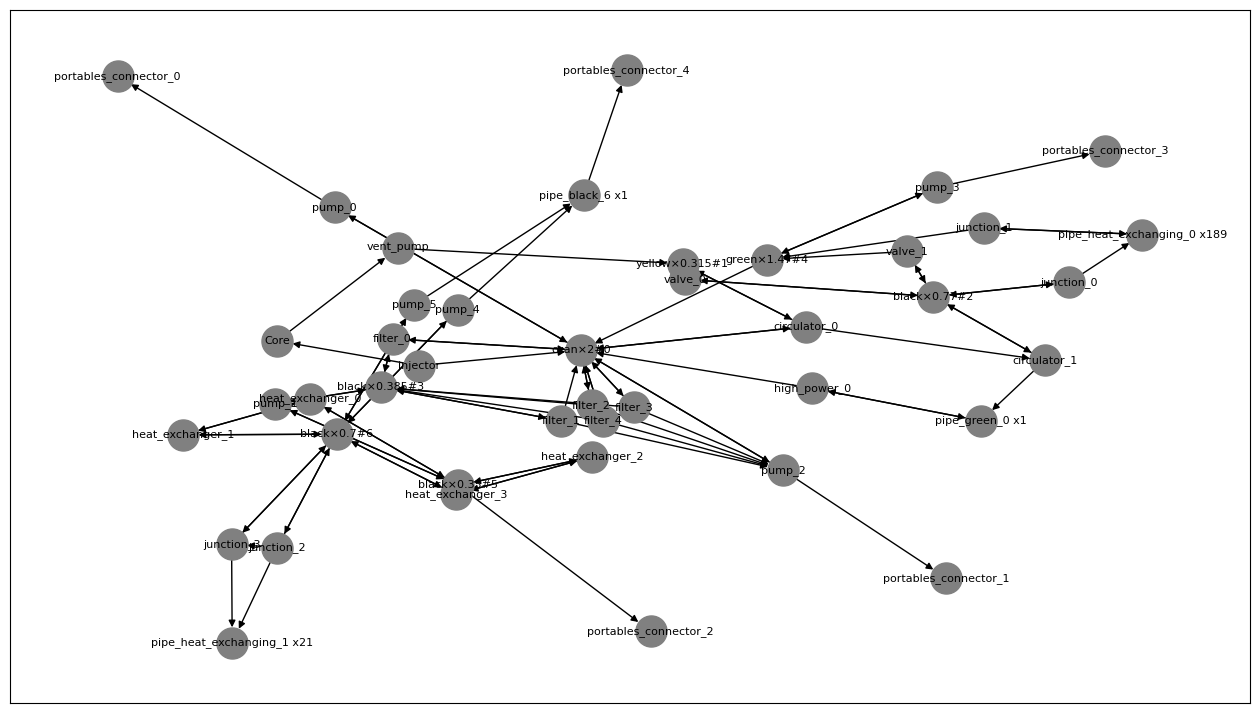

In [69]:
G = nx.DiGraph()
plt.figure(figsize=(16,9))
G.add_nodes_from(newnodes)
G.add_edges_from(newedges)
nx.draw_networkx(G, nx.spring_layout(G, k=.3), font_size=8, node_size=500, node_color='gray')

In [40]:
nx.approximation.max_clique(G)

NetworkXNotImplemented: not implemented for directed type

In [81]:
G.nodes[1]

{'label': 'ass', 'time': '5pm'}